In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy.stats.distributions import halfcauchy
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from factor_analyzer import FactorAnalyzer
import joblib
import os
import matplotlib.font_manager as font_manager


## preparing the data

In [18]:
qns = pd.read_csv(r'data\data_cleaned.csv') # the cbcl data
X = qns.iloc[:,2:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.4)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

# Tune the model

## model with residual connection

In [19]:
# # Create PyTorch datasets and dataloaders
# class QuestionnaireDataset(Dataset):
#     def __init__(self, data):
#         self.data = torch.tensor(data, dtype=torch.float32)
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         return self.data[idx], self.data[idx]  # Input and target are the same

# train_dataset = QuestionnaireDataset(X_train)
# val_dataset = QuestionnaireDataset(X_val)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # Step 2: Define the autoencoder architecture
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Autoencoder, self).__init__()
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(True),
#             # nn.Dropout(0.2),  # 添加 Dropout
#             nn.Linear(64, 32),
#             nn.ReLU(True),
#             nn.Linear(32, latent_dim),
#         )
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 32),
#             nn.ReLU(True),
#             # nn.Dropout(0.2),  # 添加 Dropout
#             nn.Linear(32, 64),
#             nn.ReLU(True),
#             nn.Linear(64, input_dim),
#         )
        
#     def forward(self, x):
#         latent = self.encoder(x)
#         reconstructed = self.decoder(latent)
#         return reconstructed + x # residual connection

# input_dim = X_train.shape[1]
# latent_dim = 5  # Reduce to 5 dimensions

# model = Autoencoder(input_dim, latent_dim)

# # Step 3: Train the autoencoder
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)  

# num_epochs = 2000
# patience = 10
# best_val_loss = float('inf')
# epochs_without_improvement = 0

# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for batch_features, _ in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_features)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * batch_features.size(0)
#     train_loss /= len(train_loader.dataset)
#     train_losses.append(train_loss)
    
#     # Validation
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch_features, _ in val_loader:
#             outputs = model(batch_features)
#             loss = criterion(outputs, batch_features)
#             val_loss += loss.item() * batch_features.size(0)
#     val_loss /= len(val_loader.dataset)
#     val_losses.append(val_loss)
#     scheduler.step(val_loss)
#     current_lr = optimizer.param_groups[0]['lr']
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, Learning Rate: {current_lr:.7f}')

#     # 检查 Early Stopping 条件
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_without_improvement = 0  # 重置计数器
#     else:
#         epochs_without_improvement += 1
    
#     if epochs_without_improvement >= patience:
#         print(f'Early stopping at epoch {epoch+1}')
#         break

# # Plot the loss curves from the second epoch, as the first epoch loss is usually much larger than the rest
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses[1:], label='Train Loss')
# plt.plot(val_losses[1:], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Validation Loss Curves')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Step 4: Extract the latent features
# model.eval()
# with torch.no_grad():
#     reconstructed = model(torch.tensor(X, dtype=torch.float32))
#     X_latent = model.encoder(torch.tensor(X, dtype=torch.float32)).numpy()
#     reconstruction_errors = torch.mean((torch.tensor(X, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

# total_variance = np.var(X, axis=0).sum()
# latent_df_99 = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])
# # 计算每个因子贡献的方差
# # 通过重建数据的方差贡献，计算解释率
# reconstruction_variance = np.var(reconstructed.numpy(), axis=0).sum()

# # 计算方差解释率
# explained_variance_ratio = reconstruction_variance / total_variance
# print(f"Explained variance ratio: {explained_variance_ratio:.8f}")

## original model without residual connection

c:\Anaconda\envs\mne\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/2000], Train Loss: 0.034661791262, Val Loss: 0.030631052661, Learning Rate: 0.0010000
Epoch [2/2000], Train Loss: 0.028990705801, Val Loss: 0.027582417394, Learning Rate: 0.0010000
Epoch [3/2000], Train Loss: 0.027062799488, Val Loss: 0.026828550654, Learning Rate: 0.0010000
Epoch [4/2000], Train Loss: 0.026525440226, Val Loss: 0.026369191174, Learning Rate: 0.0010000
Epoch [5/2000], Train Loss: 0.026261134313, Val Loss: 0.026192581337, Learning Rate: 0.0010000
Epoch [6/2000], Train Loss: 0.026091234578, Val Loss: 0.026095937584, Learning Rate: 0.0010000
Epoch [7/2000], Train Loss: 0.025952790041, Val Loss: 0.025954578532, Learning Rate: 0.0010000
Epoch [8/2000], Train Loss: 0.025825173984, Val Loss: 0.025835052126, Learning Rate: 0.0010000
Epoch [9/2000], Train Loss: 0.025724356521, Val Loss: 0.025822905325, Learning Rate: 0.0010000
Epoch [10/2000], Train Loss: 0.025632645417, Val Loss: 0.025713507399, Learning Rate: 0.0010000
Epoch [11/2000], Train Loss: 0.025557256143, Val 

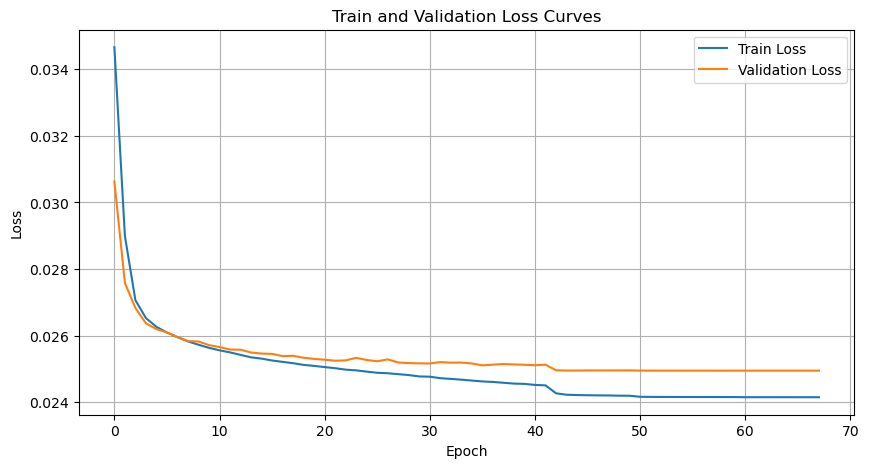

Explained variance ratio: 0.34168835


In [20]:
# Create PyTorch datasets and dataloaders
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            # nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            # nn.Dropout(0.2),  # 添加 Dropout
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
latent_dim = 5  # Reduce to 5 dimensions

model = Autoencoder(input_dim, latent_dim)

# Step 3: Train the autoencoder
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)  

num_epochs = 2000
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, _ in val_loader:
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item() * batch_features.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, Learning Rate: {current_lr:.7f}')

    # 检查 Early Stopping 条件
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # 重置计数器
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# # Step 4: Extract the latent features
# model.eval()
# with torch.no_grad():
#     # Transform the entire dataset
#     X_latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()
#     reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32)).numpy()
   
# # The variable X_latent now contains the 5-dimensional representation of your data
# # You can convert it back to a DataFrame if needed
# latent_df = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])

# # 使用 sklearn 的 explained_variance_score 计算解释方差
# explained_variance = explained_variance_score(X_scaled, reconstructed, multioutput='uniform_average')

# print(f"Explained Variance Score: {explained_variance:.8f}")

model.eval()
with torch.no_grad():
    reconstructed = model(torch.tensor(X, dtype=torch.float32))
    X_latent = model.encoder(torch.tensor(X_scaled, dtype=torch.float32)).numpy()
    reconstruction_errors = torch.mean((torch.tensor(X, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

total_variance = np.var(X, axis=0).sum()
latent_df = pd.DataFrame(X_latent, columns=[f'Factor_{i+1}' for i in range(latent_dim)])
# 计算每个因子贡献的方差
# 通过重建数据的方差贡献，计算解释率
reconstruction_variance = np.var(reconstructed.numpy(), axis=0).sum()

# 计算方差解释率
explained_variance_ratio = reconstruction_variance / total_variance
print(f"Explained variance ratio: {explained_variance_ratio:.8f}")

## interpretability

### results from autoencoder

In [21]:
# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = latent_df.values if isinstance(latent_df, pd.DataFrame) else latent_df
original_features = X if isinstance(X, np.ndarray) else X.values

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]

loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(loadings, columns=[f'Latent_{j+1}' for j in range(n_latent_factors)])
loadings_df.index = [f'Feature_{i+1}' for i in range(n_original_features)]

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）the loading matrix of the autoencoder
print(loadings_df)


             Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Feature_1   -0.265029 -0.346419  0.131743 -0.116305  0.239019
Feature_2   -0.568505 -0.166846  0.169301 -0.535175 -0.640920
Feature_3   -0.334087 -0.704622  0.323707 -0.138643  0.323725
Feature_4   -0.274106  0.007974  0.046461 -0.125369  0.091520
Feature_5   -0.038735 -0.013118  0.002536 -0.015983  0.023852
...               ...       ...       ...       ...       ...
Feature_110 -0.076281 -0.083516 -0.022456 -0.043096  0.041929
Feature_111 -0.366065 -0.048236  0.328434 -0.357484 -0.184945
Feature_112 -0.014641 -0.000282  0.004786 -0.006300  0.011297
Feature_113 -0.269287  0.059321  0.043885 -0.087412  0.184751
Feature_114 -0.379645  0.234258  0.851842 -0.399083  0.198806

[114 rows x 5 columns]


In [22]:
loadings_df.index = qns.iloc[:,2:].columns
df = pd.DataFrame()
for i in range(5):
    df0 = loadings_df['Latent_{0}'.format(i+1)].reindex(
        loadings_df['Latent_{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='Latent_{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name'})
    df = pd.concat([df, df0], axis=1)
df_even_columns = df.iloc[:, ::2]  # # Select all rows and every second column from the DataFrame

In [23]:
from utils import translate_text
from utils import get_cbcl_details
# get_cbcl_details(loadings_df)
details_autoencoder = translate_text(df_even_columns, 5,'en')
details_autoencoder.to_csv('output/details_autoencoder.csv', index=False)
details_autoencoder

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,Worries Se preocupa mucho,Worries He worries a lot,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Argues a lot Discute mucho,Argues a lot Argues a lot
1,"Stubborn, sullen, or irritable Obstinado(a), m...","Stubborn, sullen, or irritable","Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long",Feels they have to be perfect,Feels they have to be perfect,Argues a lot Discute mucho,Argues a lot Argues a lot,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long"
2,Too shy or timid Demasiado tímido(a),Too shy or timid,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,"Stubborn, sullen, or irritable Obstinado(a), m...","Stubborn, sullen, or irritable",Too shy or timid Demasiado tímido(a),Too shy or timid
3,Argues a lot Discute mucho,Argues a lot Argues a lot,Fails to finish things they start,Fails to finish things they start,Can't get their mind off certain thoughts; obs...,Can't get their mind off certain thoughts; obs...,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted
4,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...,Impulsive or acts without thinking Impulsivo(a...,Impulsive or acts without thinking Impulsive(a...,Talks too much Habla demasiado,Talks too much,Disobedient at home Desobedece en casa,Disobedient at home,Daydreams or gets lost in their thoughts,Daydreams or gets lost in their thoughts
...,...,...,...,...,...,...,...,...,...,...
109,Plays with own sex parts too much Se toca/jueg...,Plays with own sex parts too much,Runs away from home Se fuga de la casa,Runs away from home,Thumb-sucking Se chupa el dedo,Thumb-sucking,Speech problem Problemas con el habla (describa),Speech problem Problems with speech (describe),Deliberately harms self or attempts suicide Se...,Deliberately harms self or attempts suicide De...
110,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires,Problems with eyes (not if corrected by glasse...,Problems with eyes (not if corrected by glasse...,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Aches or pains (not stomach or headaches) Dolo...,Aches or pains (not stomach or headaches)
111,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex,Wets self during the day Se orina en la ropa d...,Wets himself during the day He urinates on his...,Bowel movements outside toilet Hace sus necesi...,Bowel movements outside toilet He relieves him...,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public
112,Plays with own sex parts in public Se toca/jue...,Plays with own sex parts in public,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Thinks about sex too much Parece pensar demasi...,Thinks about sex too much He seems to think to...,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex,Headaches Dolores de cabeza,Headaches Headaches


### results from NMF

In [24]:
label = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_H.csv').iloc[:,1:]
label.index = qns.iloc[:,2:].columns
df_NMF = pd.DataFrame()
for i in range(5):
    df0 = label['V{0}'.format(i+1)].reindex(
        label['V{0}'.format(i+1)].abs().sort_values(ascending=False).index
    ).to_frame(name='V{0}'.format(i+1))
    df0 = df0.reset_index().rename(columns={'index': 'Row_Name{0}'.format(i+1)})
    df_NMF = pd.concat([df_NMF, df0], axis=1)
df_NMF_even_columns = df_NMF.iloc[:, ::2]  # 选择所有行和每隔两列的列

In [25]:
details = translate_text(df_NMF_even_columns, 5,'en')
details.to_csv('output/details_NMF.csv',index=False)
details

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Headaches Dolores de cabeza,Headaches Headaches,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted,Disobedient at home Desobedece en casa,Disobedient at home
1,"Picks nose, skin, or other parts of body Mete ...","Picks nose, skin, or other parts of body Picks...",Stomachaches Dolores de estómago,Stomachaches Stomach aches,Worries Se preocupa mucho,Worries He worries a lot,"Can't concentrate, can't pay attention for lon...","Can't concentrate, can't pay attention for long","Breaks rules at home, school or elsewhere No r...","Breaks rules at home, school or elsewhere Does..."
2,Argues a lot Discute mucho,Argues a lot Argues a lot,Rashes or other skin problems Salpullido o irr...,Rashes or other skin problems,Feels they have to be perfect,Feels they have to be perfect,"Can't sit still, restless, or hyperactive No p...","Can't sit still, restless, or hyperactive Can'...",Argues a lot Discute mucho,Argues a lot Argues a lot
3,"Bragging, boasting Es engreído(a), presumido(a)","Bragging, boasting He/she is conceited, presum...",Aches or pains (not stomach or headaches) Dolo...,Aches or pains (not stomach or headaches),Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,Fails to finish things they start,Fails to finish things they start,Temper tantrums or hot temper Le dan rabietas ...,Temper tantrums or hot temper He throws tantru...
4,Disobedient at home Desobedece en casa,Disobedient at home,Overweight Tiene sobrepeso,Overweight He is overweight,Too shy or timid Demasiado tímido(a),Too shy or timid,Daydreams or gets lost in their thoughts,Daydreams or gets lost in their thoughts,Lying or cheating Dice mentiras o hace trampas,Lying or cheating Tells lies or cheats
...,...,...,...,...,...,...,...,...,...,...
109,Impulsive or acts without thinking Impulsivo(a...,Impulsive or acts without thinking Impulsive(a...,Cruel to animals Es cruel con los animales,Cruel to animals It is cruel to animals,Disobedient at home Desobedece en casa,Disobedient at home,"Constipated, doesn't move bowels Padece de est...","Constipated, doesn't move bowels Suffers from ...","Picks nose, skin, or other parts of body Mete ...","Picks nose, skin, or other parts of body Picks..."
110,Hears sound or voices that aren't there Oye so...,Hears sounds or voices that aren't there,Too fearful or anxious Demasiado ansioso(a) o ...,Too fearful or anxious,Sets fires Prende fuegos/inicia incendios,Sets fires/starts fires,Bites fingernails Se come/muerde las uñas,Bites fingernails He/she eats/bites his/her nails,Poorly coordinated or clumsy Mala coordinación...,Poorly coordinated or clumsy
111,Hangs around with others who get in trouble Se...,Hangs around with others who get in trouble,"Cruelty, bullying, or meanness to others Es cr...","Cruelty, bullying, or meanness to others He/sh...",Lying or cheating Dice mentiras o hace trampas,Lying or cheating Tells lies or cheats,Hears sound or voices that aren't there Oye so...,Hears sounds or voices that aren't there,Self-conscious or easily embarrassed Se cohíbe...,Self-conscious or easily embarrassed He/she is...
112,Gets teased a lot Los demás se burlan de él/el...,Gets teased a lot Others often make fun of him...,Not liked by other kids No le cae bien a otros...,Not liked by other kids Other children/young p...,Destroys things belonging to their family or o...,Destroys things belonging to their family or o...,Hangs around with others who get in trouble Se...,Hangs around with others who get in trouble,Too shy or timid Demasiado tímido(a),Too shy or timid


## draw the reconstuction error of the autoencoder model

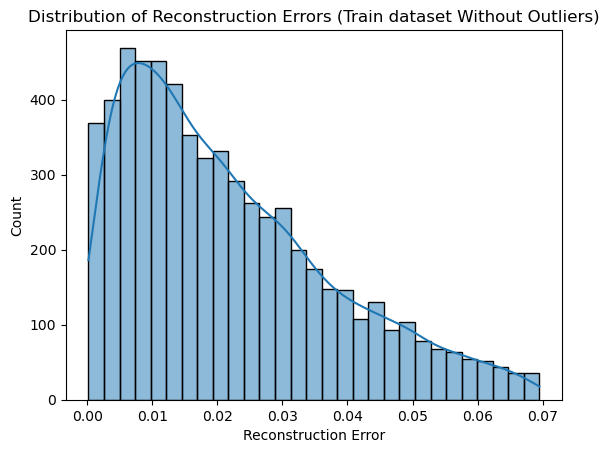

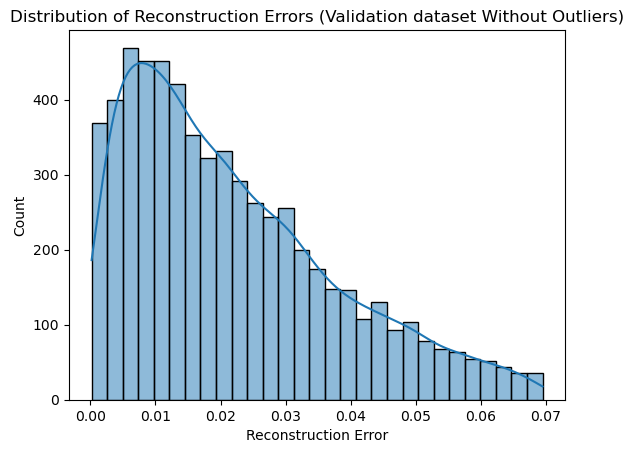

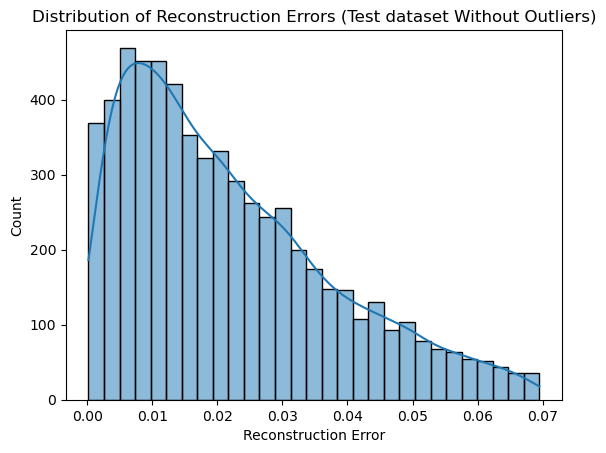

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

datasets = {'Train': X_train, 'Validation': X_val, 'Test': X_test}

model.eval()
with torch.no_grad():
    for name, dataset in datasets.items():
        # 计算验证集的重构误差
        reconstructed = model(torch.tensor(X_train, dtype=torch.float32))
        reconstruction_errors = torch.mean((torch.tensor(X_train, dtype=torch.float32) - reconstructed) ** 2, dim=1).numpy()

        # 计算四分位数
        q1 = np.percentile(reconstruction_errors, 25)
        q3 = np.percentile(reconstruction_errors, 75)
        iqr = q3 - q1

        # 定义一个范围，通常选择 1.5 倍的 IQR 来识别离群点
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # 过滤掉离群点
        filtered_errors = reconstruction_errors[(reconstruction_errors >= lower_bound) & (reconstruction_errors <= upper_bound)]

        # 绘制重构误差的分布
        sns.histplot(filtered_errors, kde=True)
        plt.xlabel('Reconstruction Error')
        plt.title(f'Distribution of Reconstruction Errors ({name} dataset Without Outliers)')
        plt.show()


## compare with EFA

In [33]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(X_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev
factor_loadings = fa.loadings_
# 计算每个因子的贡献方差和方差解释率
variance_explained = fa.get_factor_variance()
print(f"varience explained: {variance_explained[2][-1]:.2%}")

varience explained: 24.05%


## lasso regression model from questionnaire items to factors generated with NMF (from Toby)

In [28]:
qns = X
scores = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_W.csv').iloc[:,2:]

clf = MLPRegressor()
alpha_values = [0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
r2_values = np.empty((5, len(alpha_values)))
n_items = np.empty(len(alpha_values))

for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha=alpha)
    clf.fit(qns, scores)
    pred = cross_val_predict(clf, qns, scores, cv=5)
    for i in range(5):
        r2_values[i, n] = r2_score(scores.iloc[:, i], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis=1).sum()
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
# matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2', '#f9a800', '#00a087']
f, ax = plt.subplots(dpi=100, facecolor='white')
for i in range(5):
    ax.plot(n_items, r2_values[i, :], label='Factor {0}'.format(i+1), color=pal[i])
ax.set_xlabel("Number of items")
ax.set_ylabel("$R^2$")
ax.legend()
ax2 = ax.twiny()
ax2.set_xticklabels(alpha_values)
ax2.set_xticks(n_items)
ax.axvline(63, color='#8c8a8a', linestyle=':')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()

# plt.savefig('../figures/number_of_questions.svg')
clf = Lasso(alpha=0.125)
pred = cross_val_predict(clf, qns, scores, cv=5)
clf.fit(qns, scores);
f, ax = plt.subplots(1, 5, figsize=(16, 3.5), dpi=100, facecolor='white')

factors = ['V1', 'V2', 'V3','V4' ,'V5']

for i in range(5):
    sns.regplot(x = scores.iloc[:, i], y =  pred[:, i], ax=ax[i], color=pal[i], scatter_kws={'alpha': 0.5})
    ax[i].set_title(factors[i] + '\n$R^2$ = {0}'.format(np.round(r2_score(scores.iloc[:, i], pred[:, i]), 5)), fontweight='light')
    ax[i].set_xlabel('True score')
    ax[i].set_ylabel('Predicted score')
    
plt.tight_layout()
# plt.savefig('../figures/factor_prediction.svg')
plt.figure(dpi=100, figsize=(9, 1.5), facecolor='white')
sns.heatmap(clf.coef_, cmap='Blues', yticklabels=['V1', 'V2', 'V3', 'V4', 'V5'])
plt.xlabel("Question number")
plt.ylabel("Factor")
# plt.savefig('../figures/all_question_coefs.svg')

  0%|          | 0/13 [00:04<?, ?it/s]


KeyboardInterrupt: 

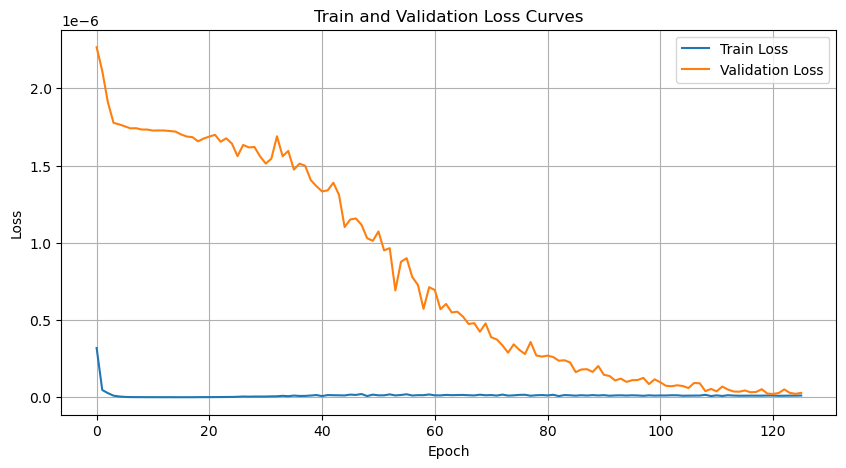

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


# To be done: 

## Test autoencoder model with different number of latent_dim (different number of factors)

In [ ]:
class QuestionnaireDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input and target are the same

train_dataset = QuestionnaireDataset(X_train)
val_dataset = QuestionnaireDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Step 2: Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = X_train.shape[1]
# latent_dim = 5  # Reduce to 5 dimensions
latent_dims = range(2, 17)
val_losses = []
explained_variance_ratios = []
for latent_dim in latent_dims:
    model = Autoencoder(input_dim, latent_dim)

    # Step 3: Train the autoencoder
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 200
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_features.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, _ in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_features)
                val_loss += loss.item() * batch_features.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        


        # 检查 Early Stopping 条件
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # 重置计数器
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    reconstructed = model(torch.tensor(X_scaled, dtype=torch.float32))
    mse = nn.MSELoss(reduction='none')
    reconstruction_error = mse(reconstructed, torch.tensor(X_scaled, dtype=torch.float32)).mean(dim=1).detach().numpy()
    print(f'Reconstruction Error: {reconstruction_error.mean()}')

    val_losses.append(val_loss)
    total_variance = np.var(X_scaled, axis=0).sum()
    # 计算每个因子贡献的方差
    # 通过重建数据的方差贡献，计算解释率
    reconstruction_variance = np.var(reconstructed.detach().numpy(), axis=0).sum()
    # 计算方差解释率
    explained_variance_ratio = reconstruction_variance / total_variance
    explained_variance_ratios.append(explained_variance_ratio)
plt.plot(latent_dims, val_losses, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Number of Latent Dimensions')
plt.show()


In [ ]:
plt.plot(latent_dims, explained_variance_ratios, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Varience Explained ratio')
plt.title('Varience Explained ratio vs. Number of Latent Dimensions')
plt.show()

## From neuroimaging data to latent factors (to be continued)

In [ ]:
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_aseg.csv")
# only keep eventname = baseline_year_1_arm_1
data = data[data['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname']).dropna()

labels = pd.read_csv(r'G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv').iloc[:, 1:]
# labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# # only keep the  column.('cbcl_scr_syn_anxdep_t')
# labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
# labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data['src_subject_id'].isin(labels["src_subject_id"])]
data = data.drop(columns=['src_subject_id'])
reshaped_array = scores.iloc[:,1].to_numpy().reshape(-1, 1)

In [ ]:
X = data  # 原始数据
y = reshaped_array  # 目标是自编码器的低维表示

# Step 1: 数据准备
# 将数据分割为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 对 X 和 y 进行标准化
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Step 2: 创建数据集和数据加载器
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RegressionDataset(X_train_tensor, y_train_tensor)
val_dataset = RegressionDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 3: 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Step 4: 定义 ResNet 风格的回归模型
class ResNetRegression(nn.Module):
    def __init__(self, input_dim, output_dim, num_blocks=3):
        super(ResNetRegression, self).__init__()
        self.input_layer = nn.Linear(input_dim, 64)
        self.hidden_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.residual_blocks(x)
        x = self.output_layer(x)
        return x

input_dim = X.shape[1]  # 原始数据的特征数量
output_dim = y.shape[1]  # 自编码器的低维表示维度
model = ResNetRegression(input_dim, output_dim)

# Step 5: 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Step 6: 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # 验证模型
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Step 7: 模型评估
model.eval()
with torch.no_grad():
    # 使用验证集进行预测
    y_val_pred_scaled = model(X_val_tensor).numpy()

    # 将预测结果逆标准化
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_val_original = scaler_y.inverse_transform(y_val_scaled)

    # 计算均方误差和 R²
    mse = mean_squared_error(y_val_original, y_val_pred)
    r2 = r2_score(y_val_original, y_val_pred)

print(f"Mean Squared Error on Validation Set: {mse:.4f}")
print(f"R² Score on Validation Set: {r2:.4f}")


Epoch [1/100], Train Loss: 1.0137, Val Loss: 1.0495
Epoch [2/100], Train Loss: 0.9852, Val Loss: 1.0556
Epoch [3/100], Train Loss: 0.9586, Val Loss: 1.0508
Epoch [4/100], Train Loss: 0.9194, Val Loss: 1.0945
Epoch [5/100], Train Loss: 0.8684, Val Loss: 1.1168
Epoch [6/100], Train Loss: 0.8130, Val Loss: 1.1215
Epoch [7/100], Train Loss: 0.7375, Val Loss: 1.1793
Epoch [8/100], Train Loss: 0.6608, Val Loss: 1.1933
Epoch [9/100], Train Loss: 0.5818, Val Loss: 1.2376
Epoch [10/100], Train Loss: 0.5012, Val Loss: 1.2953
Epoch [11/100], Train Loss: 0.4463, Val Loss: 1.3203
Epoch [12/100], Train Loss: 0.4313, Val Loss: 1.2976
Epoch [13/100], Train Loss: 0.3558, Val Loss: 1.4215
Epoch [14/100], Train Loss: 0.3178, Val Loss: 1.3991
Epoch [15/100], Train Loss: 0.2813, Val Loss: 1.4148
Epoch [16/100], Train Loss: 0.2677, Val Loss: 1.4540
Epoch [17/100], Train Loss: 0.2510, Val Loss: 1.4939
Epoch [18/100], Train Loss: 0.2328, Val Loss: 1.5608
Epoch [19/100], Train Loss: 0.2069, Val Loss: 1.5500
Ep

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

def lasso_predict_r2(X, y, alpha=0.1, test_size=0.2, random_state=42):
    """
    使用 Lasso 从数据 X 预测目标 y，并返回 R² 分数。

    参数：
    - X: ndarray or DataFrame, 原始数据。
    - y: ndarray or DataFrame, 目标变量。
    - alpha: float, Lasso 模型的正则化强度。
    - test_size: float, 测试集所占比例。
    - random_state: int, 随机种子。

    返回：
    - r2: float, R² 分数。
    """
    # Step 1: 数据划分
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Step 2: 数据标准化
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Step 3: 训练 Lasso 模型
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train_scaled)

    # Step 4: 使用测试集进行预测并计算 R² 分数
    y_pred_scaled = lasso.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)

    # 计算 R² 分数
    r2 = r2_score(y_test_original, y_pred)
    return r2

# 示例使用
# 假设 data 和 latent_df 是已加载的数据
r2 = lasso_predict_r2(data, latent_df)
print(f"R² Score: {r2:.4f}")


R² Score: -0.0001
